<a href="https://colab.research.google.com/github/somiljain7/AI-algorithms/blob/master/keras_ocr_born_digital_public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tuning recognizer with keras-ocr

This is an interactive example of the code documented in https://keras-ocr.readthedocs.io/en/latest/examples/fine_tuning_recognizer.html

In [1]:
!pip install -U git+https://github.com/faustomorales/keras-ocr.git#egg=keras-ocr
!pip install imgaug
!pip install -U opencv-python # We need the most recent version of OpenCV.
%tensorflow_version 2.x

  Cloning https://github.com/faustomorales/keras-ocr.git to /tmp/pip-install-wjcsqbxe/keras-ocr
  Running command git clone -q https://github.com/faustomorales/keras-ocr.git /tmp/pip-install-wjcsqbxe/keras-ocr
     |████████████████████████████████| 9.5MB 3.2MB/s 
     |████████████████████████████████| 819kB 43.4MB/s 
     |████████████████████████████████| 133kB 49.1MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
  Created wheel for keras-ocr: filename=keras_ocr-0.8.4-cp36-none-any.whl size=149643 sha256=4f5a0c99c58c19f9d69ad2b6bde7e8837737cae13253b5ed954e940c601e7a92
  Stored in directory: /tmp/pip-ephem-wheel-cache-llw5ue3k/wheels/ba/8d/59/67aed2a9100ea1342f8d5ce47e8b7f6ac0745ba66f5917820a
Successfully built keras-ocr
     |████████████████████████████████| 49.3MB 65kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-pyth

This example shows how to fine-tune the recognizer using an existing dataset. In this case,
we will use the "Born Digital" dataset from https://rrc.cvc.uab.es/?ch=1&com=downloads

First, we download our dataset. Below we get both the training and test datasets, but
we only use the training dataset. The training dataset consists of a single folder
containing images, each of which has a single word in it. The labels are in a text
file called `gt.txt`.

In [ ]:
import random
import string
import math
import itertools
import os

import numpy as np
import imgaug
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr

assert tf.test.is_gpu_available()

train_labels = keras_ocr.datasets.get_born_digital_recognizer_dataset(
    split='train',
    cache_dir='.'
)
test_labels = keras_ocr.datasets.get_born_digital_recognizer_dataset(
    split='test',
    cache_dir='.'
)
train_labels = [(filepath, box, word.lower()) for filepath, box, word in train_labels]
test_labels = [(filepath, box, word.lower()) for filepath, box, word in train_labels]

We next build our recognizer, using the default options to get a pretrained model.

In [ ]:
recognizer = keras_ocr.recognition.Recognizer()
recognizer.compile()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Looking for /root/.keras-ocr/crnn_kurapan.h5


We need to convert our dataset into the format that :code:`keras-ocr` requires. To 
do that, we have the following, which includes support for an augmenter to
generate synthetically altered samples. Note that this code is set up to skip
any characters that are not in the recognizer alphabet and that all labels
are first converted to lowercase.


In [ ]:
batch_size = 8
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.GammaContrast(gamma=(0.25, 3.0)),
])

train_labels, validation_labels = sklearn.model_selection.train_test_split(train_labels, test_size=0.2, random_state=42)
(training_image_gen, training_steps), (validation_image_gen, validation_steps) = [
    (
        keras_ocr.datasets.get_recognizer_image_generator(
            labels=labels,
            height=recognizer.model.input_shape[1],
            width=recognizer.model.input_shape[2],
            alphabet=recognizer.alphabet,
            augmenter=augmenter
        ),
        len(labels) // batch_size
    ) for labels, augmenter in [(train_labels, augmenter), (validation_labels, None)]     
]
training_gen, validation_gen = [
    recognizer.get_batch_generator(
        image_generator=image_generator,
        batch_size=batch_size
    )
    for image_generator in [training_image_gen, validation_image_gen]
]

As a sanity check, we show one of the samples.

text: collaboration


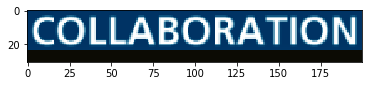

In [ ]:
image, text = next(training_image_gen)
print('text:', text)
_ = plt.imshow(image)


Now we can run training.

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, restore_best_weights=False),
    tf.keras.callbacks.ModelCheckpoint('recognizer_borndigital.h5', monitor='val_loss', save_best_only=True),
    tf.keras.callbacks.CSVLogger('recognizer_borndigital.csv')
]
recognizer.training_model.fit_generator(
    generator=training_gen,
    steps_per_epoch=training_steps,
    validation_steps=validation_steps,
    validation_data=validation_gen,
    callbacks=callbacks,
    epochs=1000,
)

Finally, run inference on a test sample.

Predicted: developer, Actual: Developer


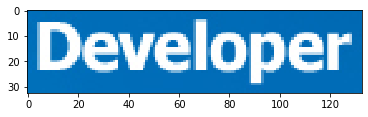

In [ ]:
image_filepath, _, actual = test_labels[1]
predicted = recognizer.recognize(image_filepath)
print(f'Predicted: {predicted}, Actual: {actual}')
_ = plt.imshow(keras_ocr.tools.read(image_filepath))